In [1]:
!pip install xlearn

Defaulting to user installation because normal site-packages is not writeable


In [6]:
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import warnings
import seaborn as sns
import datetime as dt
import os
import xlearn as xl

%matplotlib inline
warnings.filterwarnings('ignore')


In [3]:
path_to_data = './data.csv'

In [4]:
data = pd.read_csv(path_to_data)
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1240,0.067,0.035016,-7.268846,0,0.010,0.049516,-5.369901,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,0.002,0.054298,-2.657477,269,0.004,0.031942,-4.449220,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,2,0.014,0.014096,-3.824875,21,0.014,0.014906,-3.939309,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,0,1,1,3,0.012,0.015232,-3.461357,99,0.006,0.050671,-3.418403,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,0,1,0,4,0.019,0.051265,-4.009026,11464230,6.790,0.032005,-2.828797,1,1


In [5]:
data.describe()

,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
count,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582147e+07,1.582140e+07,1.582140e+07,1.582140e+07,1.582147e+07,1.580173e+07,1.580173e+07,1.580173e+07,15821472.0,1.582147e+07
mean,8.152679e+01,3.816483e+02,4.610505e+18,6.238540e-01,1.840605e+00,4.346986e+00,6.571314e+05,1.969248e-01,7.440764e-01,-3.979590e+00,2.605069e+06,1.415899e+00,5.485722e-01,-3.968883e+00,1.0,2.668835e-02
std,1.632448e+02,3.959386e+02,2.663858e+18,9.249152e+00,1.530005e+00,4.317701e+00,2.606008e+06,2.733440e+00,1.670358e+01,1.143982e+00,5.230253e+06,8.689053e+00,1.419136e+01,1.186403e+00,0.0,1.611710e-01
min,0.000000e+00,0.000000e+00,1.116911e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.763740e-02,-8.588970e+00,0.000000e+00,0.000000e+00,-6.983897e-02,-9.562188e+00,1.0,0.000000e+00
25%,1.400000e+01,5.200000e+01,2.297977e+18,0.000000e+00,1.000000e+00,0.000000e+00,7.300000e+01,5.000000e-03,1.643856e-02,-4.515871e+00,9.900000e+01,4.000000e-03,1.615219e-02,-4.529519e+00,1.0,0.000000e+00
50%,1.900000e+01,2.170000e+02,4.614236e+18,0.000000e+00,2.000000e+00,4.000000e+00,3.030000e+02,1.000000e-02,3.539307e-02,-3.921164e+00,4.600000e+02,1.400000e-02,3.556666e-02,-3.928674e+00,1.0,0.000000e+00
75%,6.000000e+01,6.110000e+02,6.914243e+18,0.000000e+00,3.000000e+00,7.000000e+00,7.200000e+02,3.000000e-02,8.022935e-02,-3.421280e+00,1.236000e+03,5.000000e-02,7.546751e-02,-3.390867e+00,1.0,0.000000e+00
max,3.443000e+03,1.632000e+03,9.223371e+18,8.290000e+02,1.000000e+01,1.600000e+01,1.146423e+07,1.000000e+02,6.910888e+02,3.149981e-01,1.462360e+07,1.000000e+02,6.910885e+02,4.756181e-01,1.0,1.000000e+00


### EDA

Удалим ненужные признаки, также избавимся от `imressions`, т.к. он не несет в себе никакой информации, далее выполним анализ, аналогично ДЗ 1

In [13]:
def drop_unnecessary_data(data: pd.DataFrame) -> pd.DataFrame:
    return data.drop(['banner_id0', 'banner_id1', 
                      'rate0', 'rate1', 'g0', 'g1',
                      'coeff_sum0', 'coeff_sum1', 'impressions'], axis=1)

In [14]:
def clean_data(data: pd.DataFrame) -> pd.DataFrame:
    cleaned_data = drop_unnecessary_data(data)
    cleaned_data.date_time = pd.to_datetime(cleaned_data.date_time)
    return cleaned_data

In [15]:
def plot_heat_map(data: pd.DataFrame):
    plt.figure(figsize=(10,7))
    cor = data.corr()
    sns.heatmap(cor, annot=True)
    plt.show()

In [16]:
def analysis(data: pd.DataFrame):
    cleaned_data = clean_data(data)
    print(f'Размер датасета: {cleaned_data.shape}')
    print(f'NaN значений в датасете: {cleaned_data.isna().values.sum()}')
    print(f'Уникальных значений в столбцах: \n{cleaned_data.nunique()}')
    plot_features(cleaned_data.iloc[:, 1:])
    print(f'Матрица корреляции: ')
    plot_heat_map(cleaned_data)

In [17]:
def plot_features(features: pd.DataFrame):
    fig, axs = plt.subplots(features.shape[1] // 2 + features.shape[1] % 2, 2, figsize=(12,9))
    for i in tqdm(range(features.shape[1])):
        axs[i // 2, i % 2].hist(features.iloc[:, i])
        axs[i // 2, i % 2].set_title(str(features.columns[i]))
    plt.tight_layout()
    plt.show()

In [18]:
cleaned_data = clean_data(data)

Размер датасета: (15821472, 8)
NaN значений в датасете: 0
Уникальных значений в столбцах: 
date_time           604712
zone_id               3444
banner_id             1633
oaid_hash          6510316
campaign_clicks        822
os_id                   11
country_id              17
clicks                   2
dtype: int64


100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  5.41it/s]


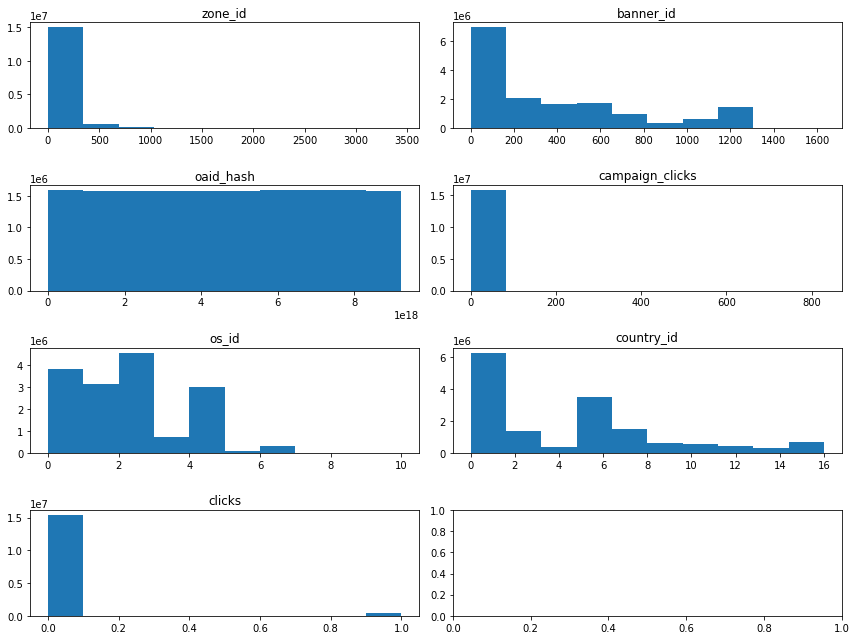

Матрица корреляции: 


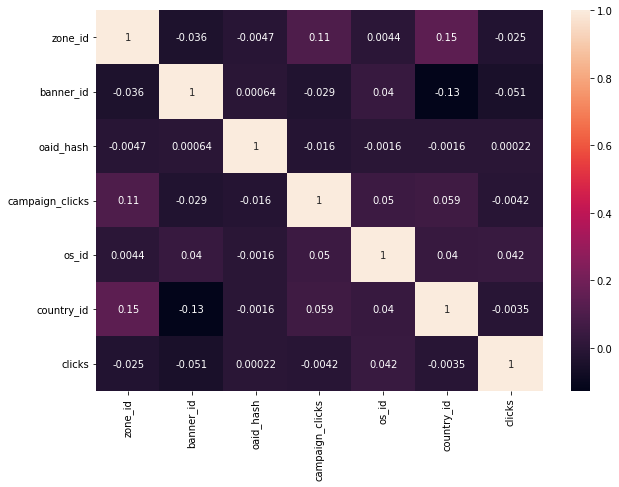

In [19]:
analysis(data)

В целом, т.к. у нас добавился лишь один признак - `oaid_hash` (который несет в себе информацию о хэше юзера), то мы можем сделать выводы, аналогичные первой работе



In [20]:
cleaned_data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,clicks
0,2021-09-27 00:01:30,0,0,5664530014561852622,0,0,0,1
1,2021-09-26 22:54:49,1,1,5186611064559013950,0,0,1,1
2,2021-09-26 23:57:20,2,2,2215519569292448030,3,0,0,1
3,2021-09-27 00:04:30,3,3,6262169206735077204,0,1,1,1
4,2021-09-27 00:06:21,4,4,4778985830203613115,0,1,0,1


In [21]:
del data

In [22]:
val_size = 0.2

In [23]:
def train_test_val_split(data):
    last_year = data.date_time.max().year
    last_month = data.date_time.max().month
    last_day = data.date_time.max().day
    latest_data = pd.Timestamp(last_year, last_month, last_day)
    test_data = data[data.date_time >= latest_data]
    train_data = data[data.date_time < latest_data]
    train_data = train_data.drop(columns=['date_time'])
    test_data = test_data.drop(columns=['date_time'])
    val_data_2 = train_data.iloc[int((1 - val_size / 2) * len(train_data)) : ]
    val_data_1 = train_data.iloc[: int((val_size / 2) * len(train_data)) ]
    train_data = train_data.iloc[int((val_size / 2) * len(train_data)) : int((1 - val_size / 2) * len(train_data))]
    val_data = pd.concat([val_data_1, val_data_2])
    return train_data, val_data, test_data

In [24]:
def feature_engineering(data):
    scaler = StandardScaler()
    data.campaign_clicks = scaler.fit_transform(data.campaign_clicks.to_frame())
    data['zone_id'] = data['zone_id'].map(str)
    data['country_id'] = data['country_id'].map(str)
    data['banner_id'] = data['banner_id'].map(str)
    data['os_id'] = data['os_id'].map(str)
    data['oaid_hash'] = data['oaid_hash'].map(str)
    data['clicks'] = data['clicks'].map(str)
    return train_test_val_split(data)

In [25]:
all_data = feature_engineering(cleaned_data)
train_data = all_data[0]
val_data = all_data[1]
test_data = all_data[2]
print(f'Train : {train_data.shape}')
print(f'Validation : {val_data.shape}')
print(f'Test : {test_data.shape}')

Train : (10953995, 7)
Validation : (2738499, 7)
Test : (2128978, 7)


In [26]:
del cleaned_data
del all_data

### FFM

Для использования Field-aware Factorization Machine (FFM) - надстройка над FM (в FM добавляется взаимодействие фичей к линейной части) используется особый формат данных, в котором должно быть, кроме значения фичи и таргета, еще и значение поля - "тип" (группа), к которой относится конкретная фича (пользователь, рекламодатель и т.д.)

Имплементация перевода в формат libffm взята из https://www.kaggle.com/code/mpearmain/pandas-to-libffm, также будем использовать библиотеку `xlearn` для FFM

In [27]:
class FFMFormatPandas:
    def __init__(self):
        self.field_index_ = None
        self.feature_index_ = None
        self.y = None

    def fit(self, df, y=None):
        self.y = y
        df_ffm = df[df.columns.difference([self.y])]
        if self.field_index_ is None:
            self.field_index_ = {col: i for i, col in enumerate(df_ffm)}

        if self.feature_index_ is not None:
            last_idx = max(list(self.feature_index_.values()))

        if self.feature_index_ is None:
            self.feature_index_ = dict()
            last_idx = 0

        for col in df.columns:
            vals = df[col].unique()
            for val in vals:
                if pd.isnull(val):
                    continue
                name = '{}_{}'.format(col, val)
                if name not in self.feature_index_:
                    self.feature_index_[name] = last_idx
                    last_idx += 1
            self.feature_index_[col] = last_idx
            last_idx += 1
        return self

    def fit_transform(self, df, y=None):
        self.fit(df, y)
        return self.transform(df)

    def transform_row_(self, row, t):
        ffm = []
        if self.y != None:
            ffm.append(str(row.loc[row.index == self.y][0]))
        if self.y is None:
            ffm.append(str(0))

        for col, val in row.loc[row.index != self.y].to_dict().items():
            col_type = t[col]
            name = '{}_{}'.format(col, val)
            if col_type.kind ==  'O':
                ffm.append('{}:{}:1'.format(self.field_index_[col], self.feature_index_[name]))
            elif col_type.kind == 'i':
                ffm.append('{}:{}:{}'.format(self.field_index_[col], self.feature_index_[col], val))
        return ' '.join(ffm)

    def transform(self, df):
        t = df.dtypes.to_dict()
        return pd.Series({idx: self.transform_row_(row, t) for idx, row in df.iterrows()})

In [28]:
ffm_converter = FFMFormatPandas()

In [29]:
ffm_test_data = ffm_converter.fit_transform(test_data, y='clicks')
ffm_test_data.to_csv('ffm_test_data.txt', index=False)

In [30]:
del ffm_test_data
del test_data

In [31]:
ffm_val_data = ffm_converter.fit_transform(val_data, y='clicks')
ffm_val_data.to_csv('ffm_val_data.txt', index=False)

In [32]:
del ffm_val_data
del val_data

In [33]:
for i in range(10):
    ffm_train_data = ffm_converter.fit_transform(train_data.iloc[int(0.1 * i * len(train_data)): int(0.1 * (i + 1) * len(train_data)), :], y='clicks')
    ffm_train_data.to_csv(f'ffm_train_data_chunk_{i}.txt', index=False)
    print(f'Chunk {i} is done!...')
    del ffm_train_data

Chunk 0 is done!...
Chunk 1 is done!...
Chunk 2 is done!...
Chunk 3 is done!...
Chunk 4 is done!...
Chunk 5 is done!...
Chunk 6 is done!...
Chunk 7 is done!...
Chunk 8 is done!...
Chunk 9 is done!...


In [34]:
def merge_train_data():
    filenames = []
    for i in range(10):
        filenames.append(f'ffm_train_data_chunk_{i}.txt')
        
    with open('ffm_train_data_all.txt', 'w') as outfile:
        for fname in filenames:
            with open(fname) as infile:
                for line in infile:
                    if line.strip() == "0":
                        continue
                    outfile.write(line)

In [35]:
merge_train_data()

In [ ]:
del train_data

Будем перебирать различные гиперпараметры для нашей FFM модели, но перебор в одной ячейке падает, т.к. kernel shutdown, поэтому делаем "ручной" GridSearch, максимизируя *auc* на валидационной выборке

In [1]:
import xlearn as xl
import os
os.environ['USER'] = 'xlearn'

In [3]:
params = {
    'task': 'binary',
    'lr': 0.001,
    'lambda': 0.0001,
    'k': 5, 
    'metric': 'auc', 
    'epoch': 20
}
print(params)
ffm_model = xl.create_ffm()
ffm_model.setTrain('./ffm_train_data_all.txt')
ffm_model.setValidate('./ffm_val_data.txt')
ffm_model.fit(params, "./xlearn.out")

{'task': 'binary', 'lr': 0.001, 'lambda': 0.0001, 'k': 5, 'metric': 'auc', 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_train_data_all.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_val_data.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6516312
[--

In [4]:
params = {
    'task': 'binary',
    'lr': 0.01,
    'lambda': 0.0001,
    'k': 5, 
    'metric': 'auc', 
    'epoch': 20
}
print(params)
ffm_model = xl.create_ffm()
ffm_model.setTrain('./ffm_train_data_all.txt')
ffm_model.setValidate('./ffm_val_data.txt')
ffm_model.fit(params, "./xlearn.out")

{'task': 'binary', 'lr': 0.01, 'lambda': 0.0001, 'k': 5, 'metric': 'auc', 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_train_data_all.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_val_data.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6516312
[---

In [5]:
params = {
    'task': 'binary',
    'lr': 0.1,
    'lambda': 0.0001,
    'k': 5, 
    'metric': 'auc', 
    'epoch': 20
}
print(params)
ffm_model = xl.create_ffm()
ffm_model.setTrain('./ffm_train_data_all.txt')
ffm_model.setValidate('./ffm_val_data.txt')
ffm_model.fit(params, "./xlearn.out")

{'task': 'binary', 'lr': 0.1, 'lambda': 0.0001, 'k': 5, 'metric': 'auc', 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_train_data_all.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_val_data.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6516312
[----

In [6]:
params = {
    'task': 'binary',
    'lr': 0.001,
    'lambda': 0.001,
    'k': 5, 
    'metric': 'auc', 
    'epoch': 20
}
print(params)
ffm_model = xl.create_ffm()
ffm_model.setTrain('./ffm_train_data_all.txt')
ffm_model.setValidate('./ffm_val_data.txt')
ffm_model.fit(params, "./xlearn.out")

{'task': 'binary', 'lr': 0.001, 'lambda': 0.001, 'k': 5, 'metric': 'auc', 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_train_data_all.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_val_data.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6516312
[---

In [7]:
params = {
    'task': 'binary',
    'lr': 0.001,
    'lambda': 0.01,
    'k': 5, 
    'metric': 'auc', 
    'epoch': 20
}
print(params)
ffm_model = xl.create_ffm()
ffm_model.setTrain('./ffm_train_data_all.txt')
ffm_model.setValidate('./ffm_val_data.txt')
ffm_model.fit(params, "./xlearn.out")

{'task': 'binary', 'lr': 0.001, 'lambda': 0.01, 'k': 5, 'metric': 'auc', 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_train_data_all.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_val_data.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6516312
[----

In [2]:
params = {
    'task': 'binary',
    'lr': 0.001,
    'lambda': 0.1,
    'k': 5, 
    'metric': 'auc', 
    'epoch': 20
}
print(params)
ffm_model = xl.create_ffm()
ffm_model.setTrain('./ffm_train_data_all.txt')
ffm_model.setValidate('./ffm_val_data.txt')
ffm_model.fit(params, "./xlearn.out")

{'task': 'binary', 'lr': 0.001, 'lambda': 0.1, 'k': 5, 'metric': 'auc', 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_train_data_all.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_val_data.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6516312
[-----

In [3]:
params = {
    'task': 'binary',
    'lr': 0.01,
    'lambda': 0.0001,
    'k': 8, 
    'metric': 'auc', 
    'epoch': 20
}
print(params)
ffm_model = xl.create_ffm()
ffm_model.setTrain('./ffm_train_data_all.txt')
ffm_model.setValidate('./ffm_val_data.txt')
ffm_model.fit(params, "./xlearn.out")

{'task': 'binary', 'lr': 0.01, 'lambda': 0.0001, 'k': 8, 'metric': 'auc', 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_train_data_all.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_val_data.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6516312
[---

In [4]:
params = {
    'task': 'binary',
    'lr': 0.001,
    'lambda': 0.0001,
    'k': 8, 
    'metric': 'auc', 
    'epoch': 20
}
print(params)
ffm_model = xl.create_ffm()
ffm_model.setTrain('./ffm_train_data_all.txt')
ffm_model.setValidate('./ffm_val_data.txt')
ffm_model.fit(params, "./xlearn.out")

{'task': 'binary', 'lr': 0.001, 'lambda': 0.0001, 'k': 8, 'metric': 'auc', 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_train_data_all.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_val_data.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6516312
[--

In [2]:
params = {
    'task': 'binary',
    'lr': 0.2,
    'lambda': 0.0001,
    'k': 10, 
    'metric': 'auc', 
    'epoch': 20
}
print(params)
ffm_model = xl.create_ffm()
ffm_model.setTrain('./ffm_train_data_all.txt')
ffm_model.setValidate('./ffm_val_data.txt')
ffm_model.fit(params, "./xlearn.out")

{'task': 'binary', 'lr': 0.2, 'lambda': 0.0001, 'k': 10, 'metric': 'auc', 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_train_data_all.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_val_data.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6516312
[---

In [4]:
params = {
    'task': 'binary',
    'lr': 0.5,
    'lambda': 0.0001,
    'k': 10, 
    'metric': 'auc', 
    'epoch': 20
}
print(params)
ffm_model = xl.create_ffm()
ffm_model.setTrain('./ffm_train_data_all.txt')
ffm_model.setValidate('./ffm_val_data.txt')
ffm_model.fit(params, "./xlearn.out")

{'task': 'binary', 'lr': 0.5, 'lambda': 0.0001, 'k': 10, 'metric': 'auc', 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_train_data_all.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_val_data.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6516312
[---

In [5]:
params = {
    'task': 'binary',
    'lr': 0.4,
    'lambda': 0.00001,
    'k': 8, 
    'metric': 'auc', 
    'epoch': 20
}
print(params)
ffm_model = xl.create_ffm()
ffm_model.setTrain('./ffm_train_data_all.txt')
ffm_model.setValidate('./ffm_val_data.txt')
ffm_model.fit(params, "./xlearn.out")

{'task': 'binary', 'lr': 0.4, 'lambda': 1e-05, 'k': 8, 'metric': 'auc', 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_train_data_all.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_val_data.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6516312
[-----

In [6]:
params = {
    'task': 'binary',
    'lr': 0.5,
    'lambda': 0.00001,
    'k': 7, 
    'metric': 'auc', 
    'epoch': 20
}
print(params)
ffm_model = xl.create_ffm()
ffm_model.setTrain('./ffm_train_data_all.txt')
ffm_model.setValidate('./ffm_val_data.txt')
ffm_model.fit(params, "./xlearn.out")

{'task': 'binary', 'lr': 0.5, 'lambda': 1e-05, 'k': 7, 'metric': 'auc', 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_train_data_all.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_val_data.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6516312
[-----

In [3]:
params = {
    'task': 'binary',
    'lr': 0.25,
    'lambda': 0.00001,
    'k': 6, 
    'metric': 'auc', 
    'epoch': 20
}
print(params)
ffm_model = xl.create_ffm()
ffm_model.setTrain('./ffm_train_data_all.txt')
ffm_model.setValidate('./ffm_val_data.txt')
ffm_model.fit(params, "./xlearn.out")

{'task': 'binary', 'lr': 0.25, 'lambda': 1e-05, 'k': 6, 'metric': 'auc', 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_train_data_all.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_val_data.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6516312
[----

In [4]:
params = {
    'task': 'binary',
    'lr': 0.2,
    'lambda': 0.001,
    'k': 8, 
    'metric': 'auc', 
    'epoch': 20
}
print(params)
ffm_model = xl.create_ffm()
ffm_model.setTrain('./ffm_train_data_all.txt')
ffm_model.setValidate('./ffm_val_data.txt')
ffm_model.fit(params, "./xlearn.out")

{'task': 'binary', 'lr': 0.2, 'lambda': 0.001, 'k': 8, 'metric': 'auc', 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_train_data_all.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_val_data.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6516312
[-----

In [5]:
params = {
    'task': 'binary',
    'lr': 0.15,
    'lambda': 0.000001,
    'k': 10, 
    'metric': 'auc', 
    'epoch': 20
}
print(params)
ffm_model = xl.create_ffm()
ffm_model.setTrain('./ffm_train_data_all.txt')
ffm_model.setValidate('./ffm_val_data.txt')
ffm_model.fit(params, "./xlearn.out")

{'task': 'binary', 'lr': 0.15, 'lambda': 1e-06, 'k': 10, 'metric': 'auc', 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_train_data_all.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_val_data.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6516312
[---

In [4]:
params = {
    'task': 'binary',
    'lr': 0.1,
    'lambda': 0.000001,
    'k': 8, 
    'metric': 'auc', 
    'epoch': 20
}
print(params)
ffm_model = xl.create_ffm()
ffm_model.setTrain('./ffm_train_data_all.txt')
ffm_model.setValidate('./ffm_val_data.txt')
ffm_model.fit(params, "./xlearn.out")

{'task': 'binary', 'lr': 0.1, 'lambda': 1e-06, 'k': 8, 'metric': 'auc', 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_train_data_all.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_val_data.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6516312
[-----

In [5]:
params = {
    'task': 'binary',
    'lr': 0.15,
    'lambda': 0.0000001,
    'k': 6, 
    'metric': 'auc', 
    'epoch': 20
}
print(params)
ffm_model = xl.create_ffm()
ffm_model.setTrain('./ffm_train_data_all.txt')
ffm_model.setValidate('./ffm_val_data.txt')
ffm_model.fit(params, "./xlearn.out")

{'task': 'binary', 'lr': 0.15, 'lambda': 1e-07, 'k': 6, 'metric': 'auc', 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_train_data_all.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_val_data.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6516312
[----

In [6]:
params = {
    'task': 'binary',
    'lr': 0.25,
    'lambda': 0.0001,
    'k': 8, 
    'metric': 'auc', 
    'epoch': 20
}
print(params)
ffm_model = xl.create_ffm()
ffm_model.setTrain('./ffm_train_data_all.txt')
ffm_model.setValidate('./ffm_val_data.txt')
ffm_model.fit(params, "./xlearn.out")

{'task': 'binary', 'lr': 0.25, 'lambda': 0.0001, 'k': 8, 'metric': 'auc', 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_train_data_all.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_val_data.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6516312
[---

In [7]:
params = {
    'task': 'binary',
    'lr': 0.1,
    'lambda': 0.000001,
    'k': 4, 
    'metric': 'auc', 
    'epoch': 20
}
print(params)
ffm_model = xl.create_ffm()
ffm_model.setTrain('./ffm_train_data_all.txt')
ffm_model.setValidate('./ffm_val_data.txt')
ffm_model.fit(params, "./xlearn.out")

{'task': 'binary', 'lr': 0.1, 'lambda': 1e-06, 'k': 4, 'metric': 'auc', 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_train_data_all.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_val_data.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6516312
[-----

In [2]:
params = {
    'task': 'binary',
    'lr': 0.1,
    'lambda': 0.00001,
    'k': 4, 
    'metric': 'auc', 
    'epoch': 20
}
print(params)
ffm_model = xl.create_ffm()
ffm_model.setTrain('./ffm_train_data_all.txt')
ffm_model.setValidate('./ffm_val_data.txt')
ffm_model.fit(params, "./xlearn.out")

{'task': 'binary', 'lr': 0.1, 'lambda': 1e-05, 'k': 4, 'metric': 'auc', 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_train_data_all.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_val_data.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6516312
[-----

In [4]:
params = {
    'task': 'binary',
    'lr': 0.1,
    'lambda': 1e-8,
    'k': 5, 
    'metric': 'auc', 
    'epoch': 20
}
print(params)
ffm_model = xl.create_ffm()
ffm_model.setTrain('./ffm_train_data_all.txt')
ffm_model.setValidate('./ffm_val_data.txt')
ffm_model.fit(params, "./xlearn.out")

{'task': 'binary', 'lr': 0.1, 'lambda': 1e-08, 'k': 5, 'metric': 'auc', 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_train_data_all.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_val_data.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6516312
[-----

In [3]:
params = {
    'task': 'binary',
    'lr': 0.1,
    'lambda': 0.00001,
    'k': 16, 
    'metric': 'auc', 
    'epoch': 20
}
print(params)
ffm_model = xl.create_ffm()
ffm_model.setTrain('./ffm_train_data_all.txt')
ffm_model.setValidate('./ffm_val_data.txt')
ffm_model.fit(params, "./xlearn.out")

{'task': 'binary', 'lr': 0.1, 'lambda': 1e-05, 'k': 16, 'metric': 'auc', 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_train_data_all.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_val_data.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6516312
[----

In [3]:
params = {
    'task': 'binary',
    'lr': 0.2,
    'lambda': 0.000001,
    'k': 10, 
    'metric': 'auc', 
    'epoch': 20
}
print(params)
ffm_model = xl.create_ffm()
ffm_model.setTrain('./ffm_train_data_all.txt')
ffm_model.setValidate('./ffm_val_data.txt')
ffm_model.fit(params, "./xlearn.out")

{'task': 'binary', 'lr': 0.2, 'lambda': 1e-06, 'k': 10, 'metric': 'auc', 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_train_data_all.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_val_data.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6516312
[----

In [2]:
params = {
    'task': 'binary',
    'lr': 0.15,
    'lambda': 0.000001,
    'k': 10, 
    'metric': 'auc', 
    'epoch': 20
}
print(params)
ffm_model = xl.create_ffm()
ffm_model.setTrain('./ffm_train_data_all.txt')
ffm_model.setValidate('./ffm_val_data.txt')
ffm_model.setTest('./ffm_test_data.txt')
ffm_model.setSigmoid()

ffm_model.fit(params, "./xlearn.out")

{'task': 'binary', 'lr': 0.15, 'lambda': 1e-06, 'k': 10, 'metric': 'auc', 'epoch': 20}
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_train_data_all.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_val_data.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 6516312
[---

In [3]:
ffm_model.predict("./xlearn.out", 'pred.txt')

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for prediction task.
[ ACTION     ] Load model ...
[------------] Load model from ./xlearn.out
[------------] Loss function: cross-entropy
[------------] Score function: ffm
[------------] Number of Feature: 6516312
[------------] Number of K: 10
[------------] Number of field: 6
[------------] Time cost for loading model: 1.60 (sec)
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (./ffm_test_data.txt.bin) found. Skip converting text to binary.
[

In [4]:
from sklearn.metrics import log_loss, roc_auc_score

In [24]:
with open ('./pred.txt') as file:
    y_pred = file.readlines()

with open ('./ffm_test_data.txt') as file:
    y_true = file.readlines()

y_true = np.array([float(i.split(' ')[0]) for i in y_true])

y_pred = np.array([float(i.strip()) for i in y_pred])

In [25]:
y_true

array([1., 1., 1., ..., 0., 0., 0.])

In [26]:
y_pred

array([3.49824e-03, 1.02061e-02, 2.30487e-03, ..., 1.93828e-04,
       1.63313e-04, 4.29960e-05])

In [29]:
ffm_log_loss = log_loss(y_true, y_pred)
ffm_roc_auc = roc_auc_score(y_true, y_pred)
print('Log Loss : ', ffm_log_loss)
print('ROC AUC : ', ffm_roc_auc)

Log Loss :  0.233116845189773
ROC AUC :  0.7616924071807241


Сравним полученные результаты с линейной моделью из ДЗ 1 и baseline (ноутбук *HW1.ipynb*):

               LogLoss      ROC AUC

 * Baseline                            $ ~~~~~~~~~~0.153~~~~~~~~~~~~~~~~~~~      0.500$
 
 * LR                  $~~~~~~~~~~~~~~~~~~0.135~~~~~~~~~~~~~~~~~~~      0.778$

 * FFM  $~~~~~~~~~~~~~~~0.233~~~~~~~~~~~~~~~~~~~      0.761$
 
 Как видим, FFM очень близок по roc auc к линейной модели, определенно лучше baseline решения, но немного меньше чем скор из 1 ДЗ. Что может быть связано с не совсем удачной идеей разделения на валидационную выборку - в нее попали значения 10% из конца и из начала, лучше было бы сделать shuffle, так же на результат влияют гиперпараметры, перебор которых затруднен дампами jupyter notebook. Кроме того, конечно определенно играет роль особенности fields в FFM